In [10]:
import pandas as pd
import numpy as np
import m2cgen as m2c


import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

%matplotlib inline

In [11]:
import os

def save_model(classifier, model_type, n_est, hz):
    code = m2c.export_to_python(classifier)
    directory = f'models/inf_time_test/{model_type}'
    os.makedirs(directory, exist_ok=True)  # Create directory if it doesn't exist
    
    PATH = f'{directory}/{model_type}_{n_est}est_{hz}hz.py'
    with open(PATH, 'w') as f:
        f.writelines(code)

    return PATH


In [12]:
def train_random_forest(X_train, X_test, y_train, y_test, n_est, hz):
    '''Trainer function for random forest classifier.'''
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import metrics
    
    clf = RandomForestClassifier(random_state=42, n_estimators=n_est)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    recall = metrics.recall_score(y_test, y_pred, average='macro')

    path = save_model(classifier=clf, model_type='random_forest', n_est=n_est, hz=hz)

    return accuracy, f1, precision, recall, clf

In [13]:
# prepare data
df_25hz = pd.read_csv('data/transformed/20210529_v2_data_all_25hz.csv').reset_index(drop=True)
df_100hz = pd.read_csv('data/transformed/20210529_v2_data_all_100hz.csv').reset_index(drop=True)

df_train_25hz = df_25hz.dropna(axis=0)
df_train_100hz = df_100hz.dropna(axis=0)

X_train_25hz, X_test_25hz, y_train_25hz, y_test_25hz = train_test_split(
        df_train_25hz.drop(['label','shift'],axis=1), df_train_25hz['label'], test_size=0.3, random_state=42)

X_train_100hz, X_test_100hz, y_train_100hz, y_test_100hz = train_test_split(
        df_train_100hz.drop(['label','shift'],axis=1), df_train_100hz['label'], test_size=0.3, random_state=42)

In [14]:
# train random forests

for n_est in [3,4,5,10]:
    print(f'\nRandom Forest - 25hz - {n_est}')
    train_random_forest(X_train_25hz, X_test_25hz, y_train_25hz, y_test_25hz, n_est, 25)
    print('-' * 60)

for n_est in [3,4,5,10]:
    print(f'\nRandom Forest - 100hz - {n_est}')
    train_random_forest(X_train_100hz, X_test_100hz, y_train_100hz, y_test_100hz, n_est, 100)
    print('-' * 60)


Random Forest - 25hz - 3
------------------------------------------------------------

Random Forest - 25hz - 4
------------------------------------------------------------

Random Forest - 25hz - 5
------------------------------------------------------------

Random Forest - 25hz - 10
------------------------------------------------------------

Random Forest - 100hz - 3
------------------------------------------------------------

Random Forest - 100hz - 4
------------------------------------------------------------

Random Forest - 100hz - 5
------------------------------------------------------------

Random Forest - 100hz - 10
------------------------------------------------------------


In [17]:
from models.inf_time_test.random_forest import (
        random_forest_3est_25hz,
        random_forest_4est_25hz,
        random_forest_5est_25hz, 
        random_forest_10est_25hz,
        random_forest_3est_100hz,
        random_forest_4est_100hz,
        random_forest_5est_100hz, 
        random_forest_10est_100hz
    )

In [18]:
test_data_25hz = pd.read_csv('data/transformed/20210529_v2_data_all_25hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]
test_data_100hz = pd.read_csv('data/transformed/20210529_v2_data_all_100hz.csv').reset_index(drop=True).drop(['label','shift'], axis=1).loc[0]

In [20]:
m2c_time_test_setup = {
    'random_forest': [
        (random_forest_3est_25hz, test_data_25hz, 25, 3),
        (random_forest_4est_25hz, test_data_25hz, 25, 4),
        (random_forest_5est_25hz, test_data_25hz, 25, 5),
        (random_forest_10est_25hz, test_data_25hz, 25, 10),
        (random_forest_3est_100hz, test_data_100hz, 100, 3),
        (random_forest_4est_100hz, test_data_100hz, 100, 4),
        (random_forest_5est_100hz, test_data_100hz, 100, 5),
        (random_forest_10est_100hz, test_data_100hz, 100, 10)
    ]
}

In [21]:
from statistics import mean

m2c_time_local = []            

for t_item in m2c_time_test_setup['random_forest']:
    model = t_item[0]
    test_data = t_item[1]
    hz = t_item[2]
    n_est = t_item[3]

    res_time = get_ipython().run_line_magic('timeit', '-o model.score(test_data)')

    # TODO fix data collection
    m2c_time_local.append({'hz':hz ,'estimators': n_est, 'time':mean(res_time.timings)})
#     m2c_time_data_rf['hz'] = hz
#     m2c_time_data_rf['estimators'] = n_est
#     m2c_time_data_rf['time'] = mean(res_time.timings)

30.2 µs ± 1.73 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
44.2 µs ± 955 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
64.8 µs ± 32 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
303 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
46.8 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
39.7 µs ± 885 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
102 µs ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
257 µs ± 23.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
m2c_time_local

[{'hz': 25, 'estimators': 3, 'time': 3.0162941428573373e-05},
 {'hz': 25, 'estimators': 4, 'time': 4.4186892857143383e-05},
 {'hz': 25, 'estimators': 5, 'time': 6.475728857142745e-05},
 {'hz': 25, 'estimators': 10, 'time': 0.0003032671142857128},
 {'hz': 100, 'estimators': 3, 'time': 4.68180899999993e-05},
 {'hz': 100, 'estimators': 4, 'time': 3.966068285714073e-05},
 {'hz': 100, 'estimators': 5, 'time': 0.00010245114714285656},
 {'hz': 100, 'estimators': 10, 'time': 0.0002571284857142798}]

In [23]:
m2c_df_local = pd.DataFrame(m2c_time_local)
m2c_df_local['device'] = 'local'
m2c_df_local['time'] = m2c_df_local['time'] * 1000 # convert to ms

m2c_df_local.to_csv('output/inference_time_rf_estimators_50hz.csv', index=False)

**Inference on ESP32**


In [24]:
# inference time means collect from ESP32 @ 160MHz
from statistics import mean

# collected data is in us
# data was collected on ESP32 at 160MHz

time_esp32_25_3 = mean([1678,1188,1175,1176,1175,1176,1175,1176,1175,1176,1176,1176,1175,1176,1176,1176,1175,1176,1176,1176])
time_esp32_25_4 = mean([2054,1575,1557,1557,1557,1557,1556,1557,1566,1557,1557,1557,1557,1557,1556,1564,1556,1556,1556,1565])
time_esp32_25_5 = mean([2490,1994,1982,1987,1982,1983,1982,1988,1982,1981,1983,1982,1988,1982,1982,1982,1990,1982,1982,1982])
time_esp32_25_10 = mean([4157,3654,3640,3640,3640,3643,3640,3643,3642,3643,3633,3635,3633,3636,3634,3636,3633,3635,3633,3636])

time_esp32_100_3 = mean([1738,1235,1226,1222,1223,1226,1223,1223,1231,1223,1222,1228,1222,1223,1230,1223,1223,1223,1222,1223])
time_esp32_100_4 = mean([2152,1648,1636,1637,1636,1645,1636,1637,1637,1637,1636,1636,1636,1636,1637,1637,1645,1636,1637,1637])
time_esp32_100_5 = mean([2638,2132,2122,2121,2129,2121,2121,2121,2122,2126,2121,2121,2122,2125,2121,2121,2122,2121,2127,2121])
time_esp32_100_10 = mean([4568,4062,4051,4053,4048,4052,4051,4046,4044,4045,4043,4046,4044,4045,4044,4046,4044,4046,4044,4044])

In [25]:
m2c_df_esp32 = pd.DataFrame([
    {'hz': 25, 'estimators': 3, 'time':time_esp32_25_3},
    {'hz': 25, 'estimators': 4, 'time':time_esp32_25_4},
    {'hz': 25, 'estimators': 5, 'time':time_esp32_25_5},
    {'hz': 25, 'estimators': 10, 'time':time_esp32_25_10},
    {'hz': 100, 'estimators': 3, 'time':time_esp32_100_3},
    {'hz': 100, 'estimators': 4, 'time':time_esp32_100_4},
    {'hz': 100, 'estimators': 5, 'time':time_esp32_100_5},
    {'hz': 100, 'estimators': 10, 'time':time_esp32_100_10}
])

m2c_df_esp32['device'] = 'esp32'
m2c_df_esp32['time'] = m2c_df_esp32['time'] / 1000

**Plot ESP32 vs Local inference times**

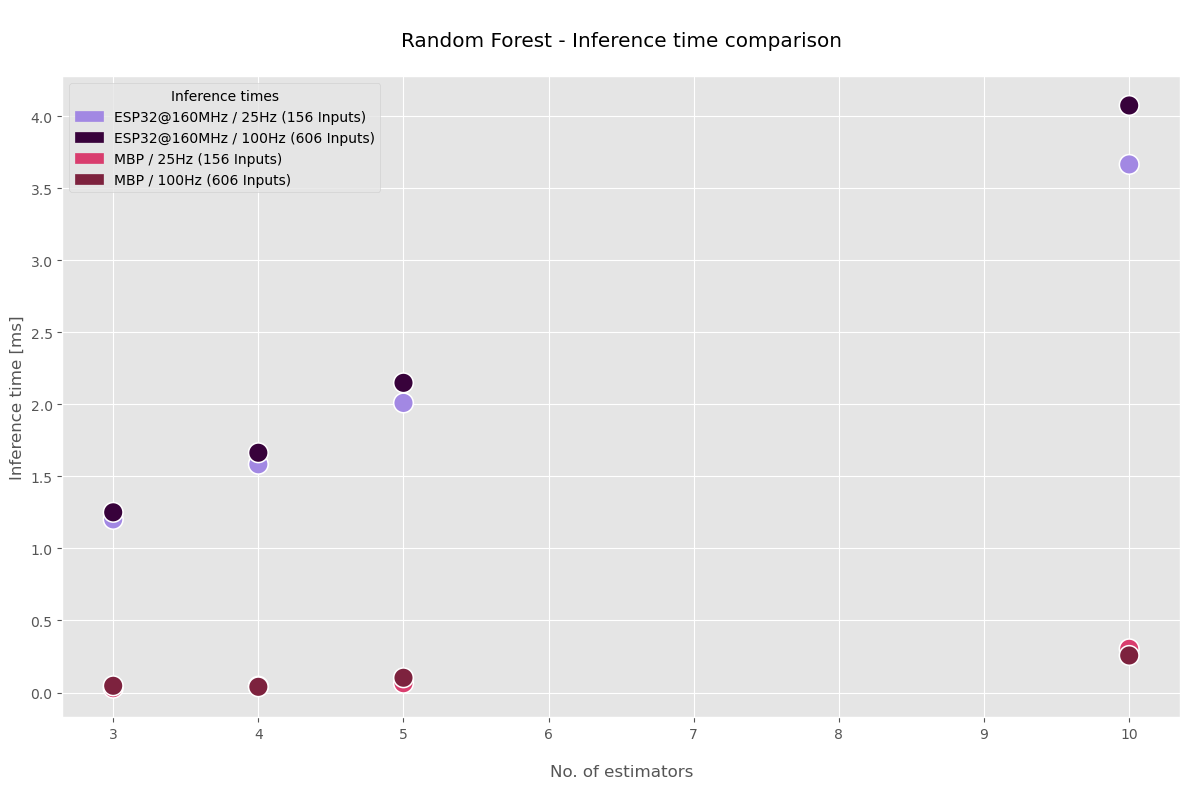

In [26]:
import matplotlib.ticker as tick
import matplotlib.patches as mpatches

plt.figure(figsize=(12,8))
color_pal_esp32  = {25:(162/255, 136/255, 227/255), 100:(56/255, 2/255, 59/255)}
color_pal_local  = {25:(217/255, 61/255, 110/255), 100:(125/255, 34/255, 62/255)}

sns.scatterplot(data=m2c_df_esp32, x='estimators', y='time', hue='hz', palette=color_pal_esp32, s=200)
sns.scatterplot(data=m2c_df_local, x='estimators', y='time', hue='hz', palette=color_pal_local, s=200)

plt.title('\nRandom Forest - Inference time comparison\n')
plt.xlabel('\nNo. of estimators')
plt.ylabel('Inference time [ms]')

# Create Legend
esp_32_25 = mpatches.Patch(color=color_pal_esp32[25], label='ESP32@160MHz / 25Hz (156 Inputs)')
esp_32_100 = mpatches.Patch(color=color_pal_esp32[100], label='ESP32@160MHz / 100Hz (606 Inputs)')
local_25 = mpatches.Patch(color=color_pal_local[25], label='MBP / 25Hz (156 Inputs)')
local_100 = mpatches.Patch(color=color_pal_local[100], label='MBP / 100Hz (606 Inputs)')
plt.legend(handles=[esp_32_25, esp_32_100, local_25, local_100], title='Inference times')

plt.tight_layout()